# Loading Generic MC

In [1]:
%load_ext autoreload
%autoreload 2

from root_pandas import read_root
import pandas as pd
from sklearn.metrics import roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from tqdm.notebook import tqdm
tqdm.pandas()
import sys
sys.path.append('/home/belle/zhangboy/inclusive_R_D/')
import utilities as util

Welcome to JupyROOT 6.24/06


In [2]:
# Ntuple locations
qqbar = '../Samples/Generic_MC14ri/MC14ri_qqbar_e_bengal_3/grid_MC_e.root'
taupair = '../Samples/Generic_MC14ri/MC14ri_taupair_e_bengal_1/grid_MC_e.root'
bbbar_0 = '../Samples/Generic_MC14ri/MC14ri_bbbar_bengal_e_1/MC14ri_bbbar_0.root'
bbbar_1 = '../Samples/Generic_MC14ri/MC14ri_bbbar_bengal_e_1/MC14ri_bbbar_1.root'
bbbar_2 = '../Samples/Generic_MC14ri/MC14ri_bbbar_bengal_e_1/MC14ri_bbbar_2.root'
bbbar_3 = '../Samples/Generic_MC14ri/MC14ri_bbbar_bengal_e_1/MC14ri_bbbar_3.root'
bbbar_4 = '../Samples/Generic_MC14ri/MC14ri_bbbar_bengal_e_1/MC14ri_bbbar_4.root'

data_samples = [qqbar, taupair, bbbar_0, bbbar_1, bbbar_2, bbbar_3, bbbar_4]
#data_samples_applied = [f.strip('root').strip('.')+'_applied.root' for f in data_samples]

training_variables = util.training_variables
variables = util.variables

total = []
for file in data_samples[:2]:
    df = read_root(file, columns=['__*__', 'D_mcPDG', 'e_mcPDG',
                                              'e_genMotherPDG','B0_mcPDG','B0_mcErrors',
                                              'B0_isContinuumEvent']+variables)
    df['DecayMode'] = 0
    df.eval('p_D_l = D_CMS_p + e_CMS_p', inplace=True)
    df.eval('B_D_ReChi2 = B0_vtxReChi2 + D_vtxReChi2', inplace=True)
    total.append(df)
    
for file in data_samples[2:]:
    df = read_root(file, columns=['__*__', 'D_mcPDG', 'e_mcPDG','DecayMode', 'p_D_l', 'B_D_ReChi2',
                                              'e_genMotherPDG','B0_mcPDG','B0_mcErrors',
                                              'B0_isContinuumEvent']+variables)
    total.append(df)
df = pd.concat(total,ignore_index=True).reset_index()

In [ ]:
pd.set_option('display.max_rows', None)
print(df.isna().sum())

# LightGBM

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

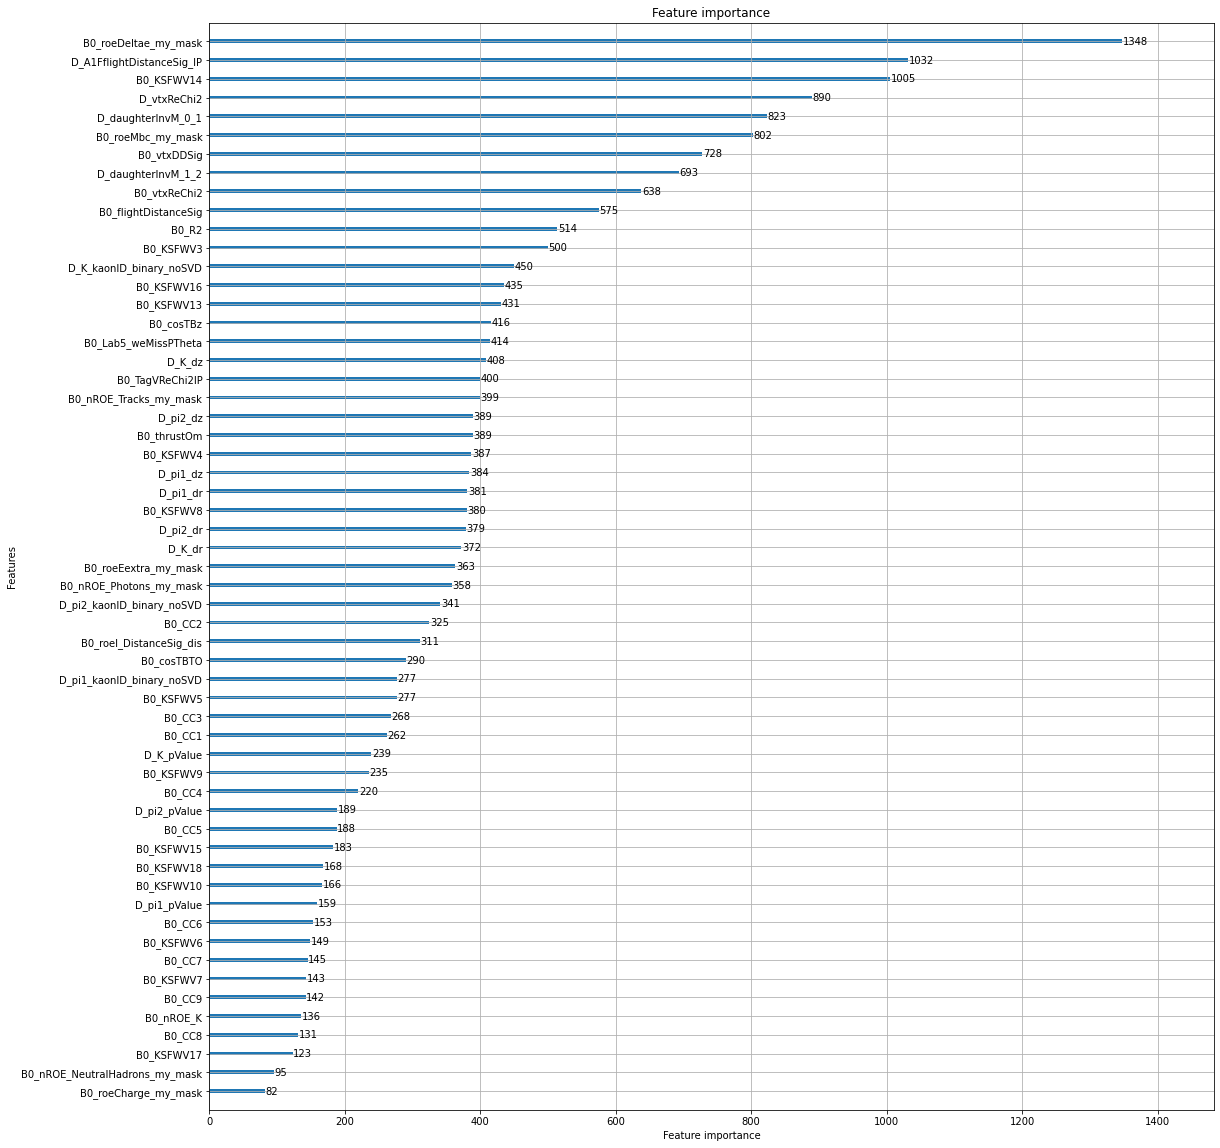

In [3]:
import lightgbm as lgb
# load model to predict
bst_lgb = lgb.Booster(model_file=f'../BDTs/LightGBM/lgbm_multiclass.txt')

# feature importances
lgb.plot_importance(bst_lgb, figsize=(18,20))

In [4]:
pred = bst_lgb.predict(df[training_variables], num_iteration=50) #bst_lgb.best_iteration
lgb_out = pd.DataFrame(pred, columns=['signal_prob','continuum_prob','fakeD_prob','fakeB_prob'])

df_lgb = pd.concat([df, lgb_out], axis=1)
df_lgb['largest_prob'] = df_lgb[['signal_prob','continuum_prob','fakeD_prob','fakeB_prob']].max(axis=1)
del pred, df, lgb_out

## Plot LightGBM results

In [ ]:
df, samples=util.get_dataframe_samples(df_lgb)

In [28]:
mpl=util.mpl(samples)
plyex=util.plyex(df)

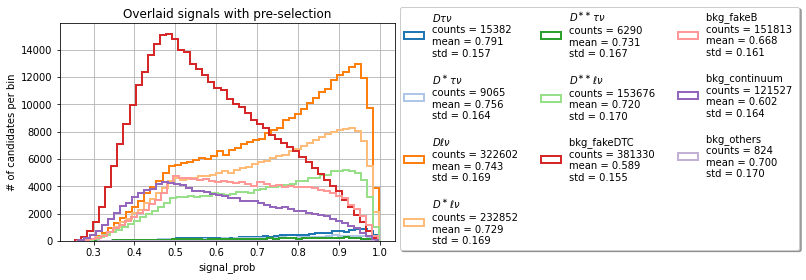

In [9]:
#'signal_prob','continuum_prob','fakeD_prob','fakeB_prob'
mpl.plot_projection(cut='signal_prob==largest_prob',variable='signal_prob')

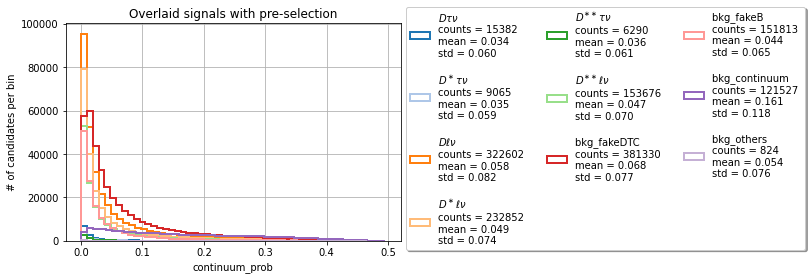

In [10]:
mpl.plot_projection(cut='signal_prob==largest_prob',variable='continuum_prob')

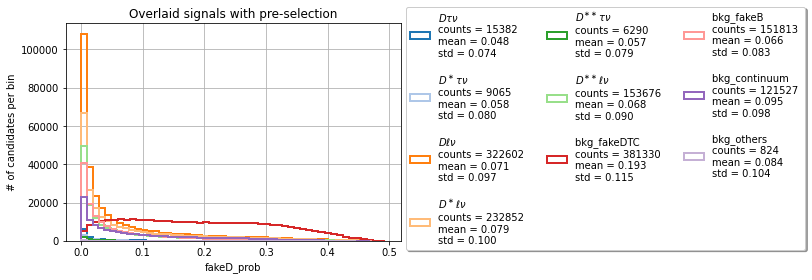

In [13]:
mpl.plot_projection(cut='signal_prob==largest_prob',variable='fakeD_prob')

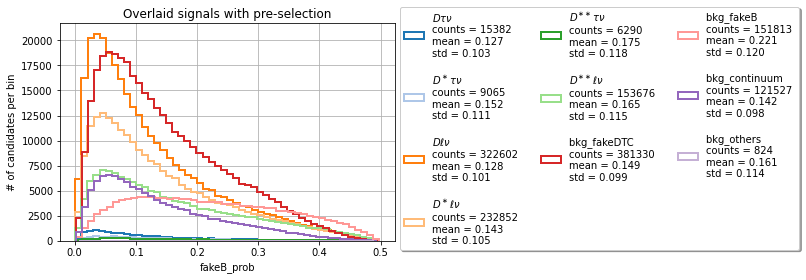

In [14]:
mpl.plot_projection(cut='signal_prob==largest_prob',variable='fakeB_prob')

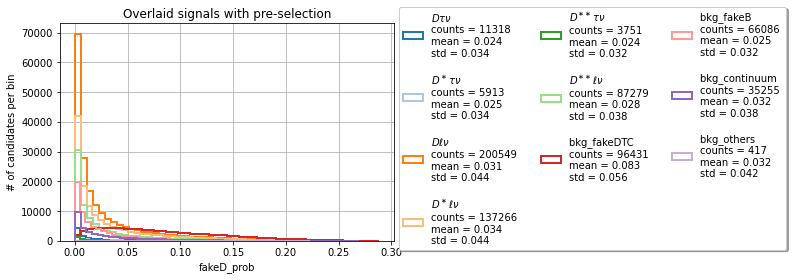

In [33]:
mpl.plot_projection(cut='signal_prob==largest_prob and signal_prob>0.7',variable='fakeD_prob')

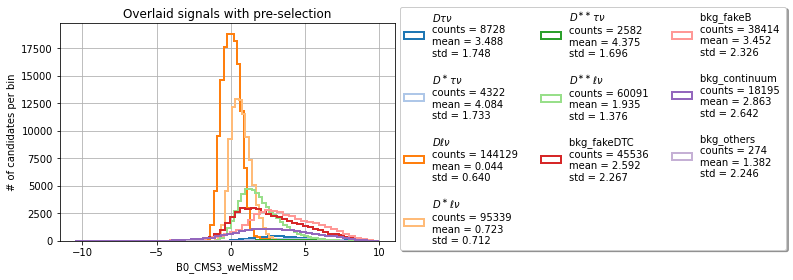

In [35]:
mpl.plot_projection(cut='signal_prob==largest_prob and signal_prob>0.8',variable='B0_CMS3_weMissM2')

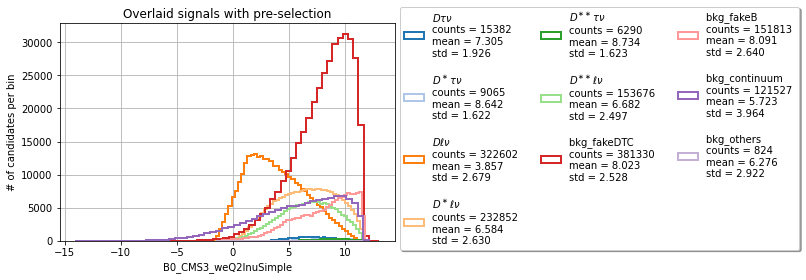

In [17]:
mpl.plot_projection(cut='signal_prob==largest_prob',variable='B0_CMS3_weQ2lnuSimple')

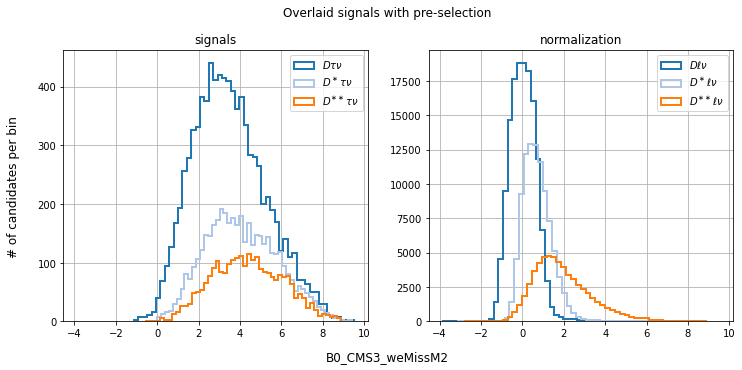

In [39]:
mpl.plot_overlaid_signals(cut='signal_prob==largest_prob and signal_prob>0.8',variable='B0_CMS3_weMissM2')

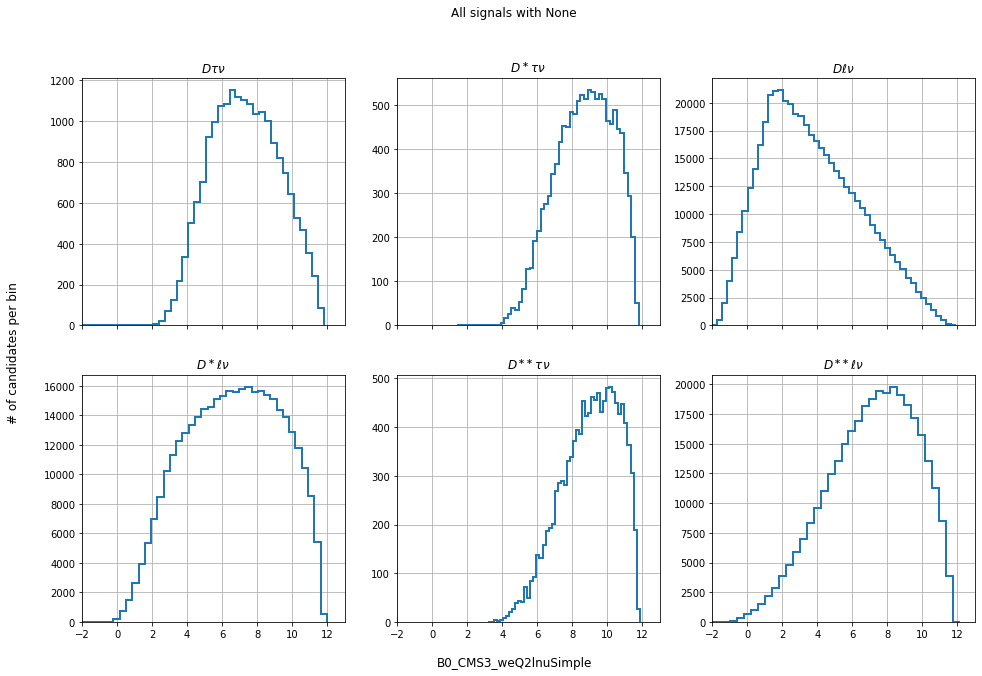

In [54]:
mpl.plot_all_signals(variable='B0_CMS3_weQ2lnuSimple',xlim=[-2,13])

In [ ]:
plyex.hist(variable='B0_CMS3_weQ2lnuSimple', cut='signal_prob==largest_prob and signal_prob>0.8')

In [ ]:
test_points = [0,0.1,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.6,0.7,0.8,0.85,0.9,0.95,0.96,0.97]
plyex.plot_FOM(sigModes=[r'$D\tau\nu$'], 
               bkgModes=['bkg_fakeDTC','bkg_fakeB','bkg_continuum','bkg_others'], 
               variable='signal_prob',test_points=test_points,
               cut='signal_prob==largest_prob')

In [ ]:
test_points = [0,0.1,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.6,0.7,0.8,0.85,0.9,0.95,0.96,0.97]
plyex.plot_FOM(sigModes=[r'$D\tau\nu$'], 
               bkgModes=['bkg_fakeDTC','bkg_fakeB','bkg_continuum','bkg_others'], 
               variable='signal_prob',test_points=test_points)

# XGBoost

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

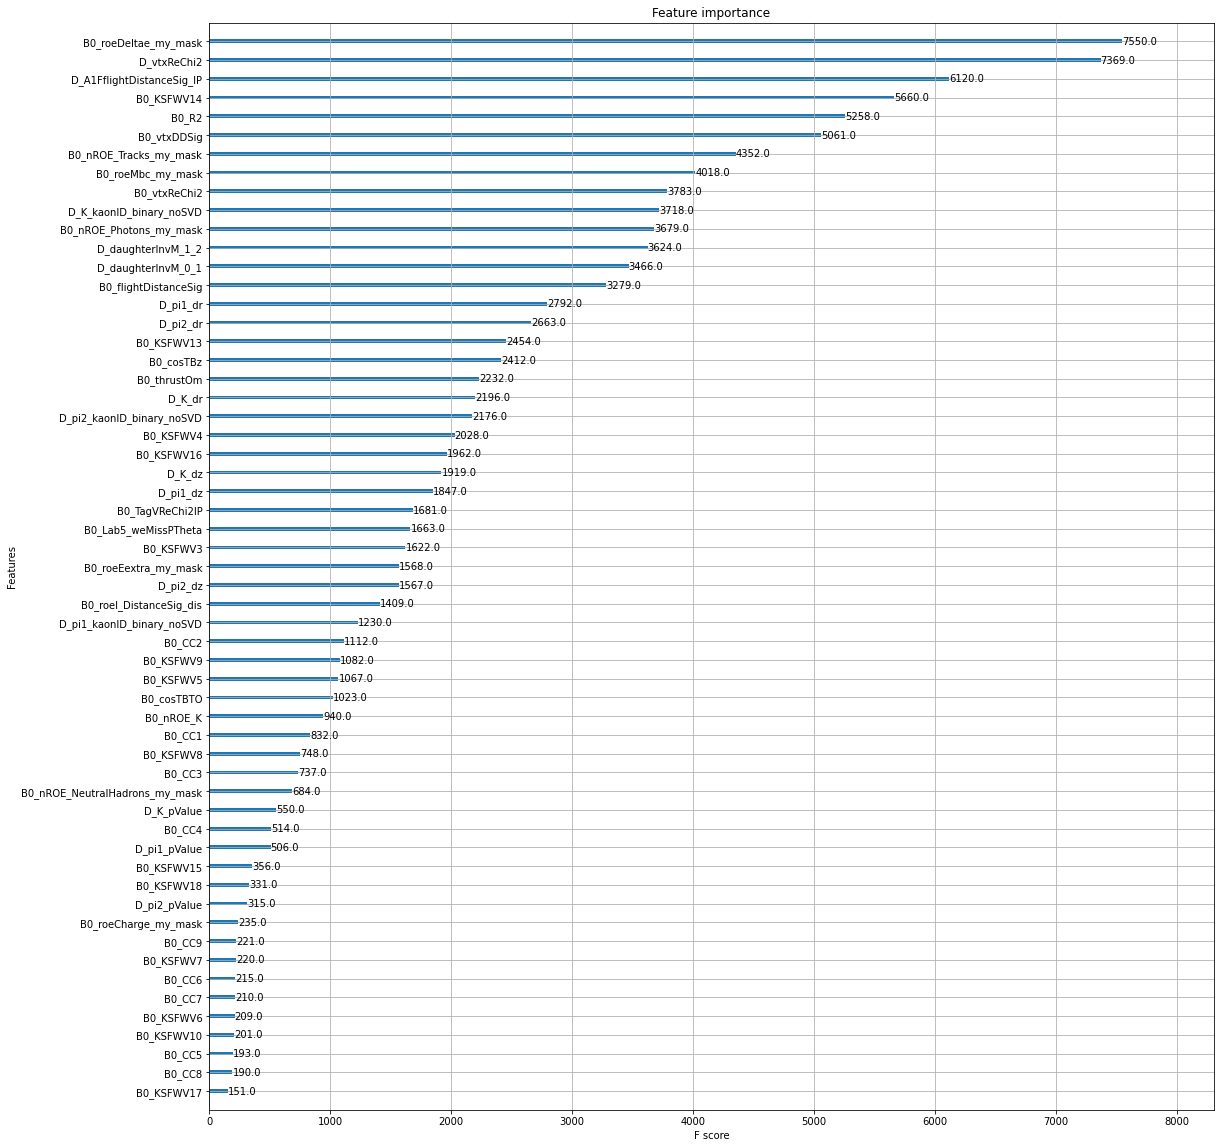

In [3]:
import xgboost as xgb
# load model to predict
bst_xgb = xgb.Booster(model_file=f'../BDTs/XGBoost/BRF_multi:softprob.json')

# feature importances
fig, ax = plt.subplots(figsize=(18, 20))
xgb.plot_importance(bst_xgb, ax=ax)

In [4]:
dtest = xgb.DMatrix(data=df[training_variables], weight=df['__weight__'])
pred = bst_xgb.predict(dtest)
xgb_out = pd.DataFrame(pred, columns=['signal_prob','continuum_prob','fakeD_prob','fakeB_prob'])

df_xgb = pd.concat([df, xgb_out], axis=1)
df_xgb['largest_prob'] = df_xgb[['signal_prob','continuum_prob','fakeD_prob','fakeB_prob']].max(axis=1)
del pred, df, xgb_out

In [12]:
df_xgb[['signal_prob','continuum_prob','fakeD_prob','fakeB_prob']].head()

,signal_prob,continuum_prob,fakeD_prob,fakeB_prob
0,0.001436,0.987234,0.006455,0.004876
1,0.000335,0.995594,0.003215,0.000856
2,0.000273,0.995439,0.003799,0.000488
3,0.003871,0.669260,0.311919,0.014950
4,0.031746,0.666126,0.274628,0.027500


In [5]:
df, samples=util.get_dataframe_samples(df_xgb)

In [6]:
mpl=util.mpl(samples)
plyex=util.plyex(df)

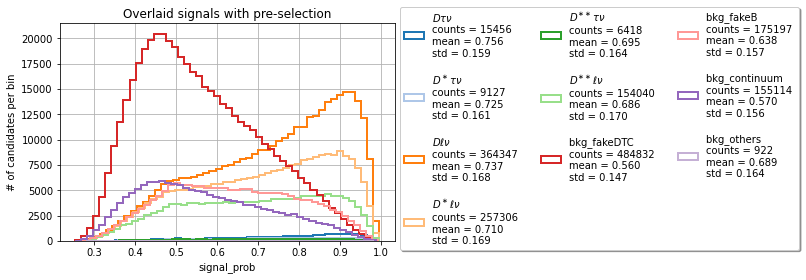

In [7]:
mpl.plot_projection(cut='signal_prob==largest_prob',variable='signal_prob')

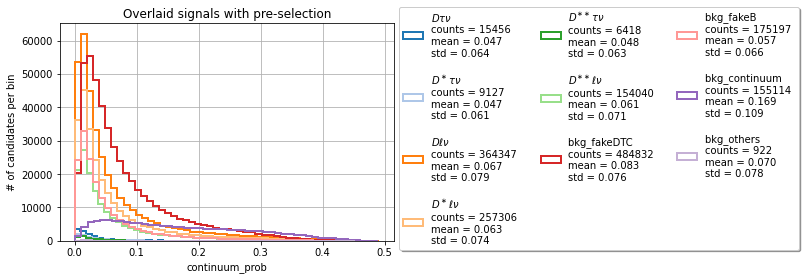

In [8]:
mpl.plot_projection(cut='signal_prob==largest_prob',variable='continuum_prob')

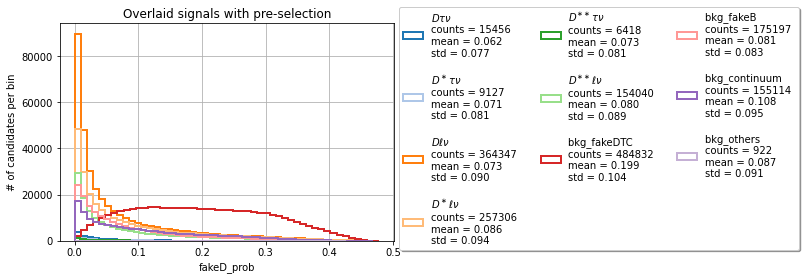

In [9]:
mpl.plot_projection(cut='signal_prob==largest_prob',variable='fakeD_prob')

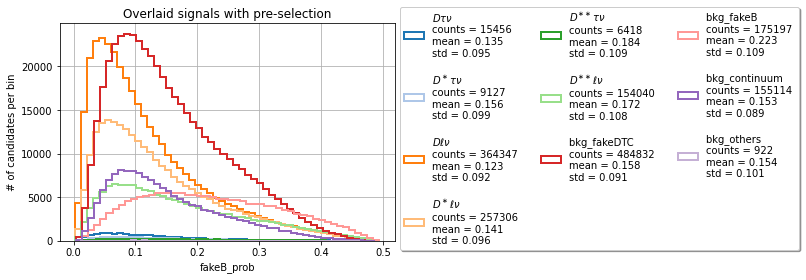

In [10]:
mpl.plot_projection(cut='signal_prob==largest_prob',variable='fakeB_prob')

In [ ]:
test_points = [0,0.1,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.6,0.7,0.8,0.85,0.9,0.95,0.96,0.97]
plyex.plot_FOM(sigModes=[r'$D\tau\nu$'], 
               bkgModes=['bkg_fakeDTC','bkg_fakeB','bkg_continuum','bkg_others'], 
               variable='signal_prob',test_points=test_points,
               cut='signal_prob==largest_prob')

In [ ]:
test_points = [0,0.1,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.6,0.7,0.8,0.85,0.9,0.95,0.96,0.97]
plyex.plot_FOM(sigModes=[r'$D\tau\nu$'], 
               bkgModes=['bkg_fakeDTC','bkg_fakeB','bkg_continuum','bkg_others'], 
               variable='signal_prob',test_points=test_points)